In [1]:
%load_ext cudf.pandas

In [2]:
import cuml as ml
import numpy as np
import cupy as cp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

In [3]:
df = pd.read_csv('telecom_customer_churn.csv')
zippop = pd.read_csv('telecom_zipcode_population.csv')

In [4]:
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,<NA>,<NA>
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,<NA>,<NA>
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [5]:
zippop.head()

,Zip Code,Population
0,90001,54492
1,90002,44586
2,90003,58198
3,90004,67852
4,90005,43019


In [6]:
df_merge = df.merge(zippop, how = 'left', on = 'Zip Code')
df_merge.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Customer ID                        7043 non-null   object
 1   Gender                             7043 non-null   object
 2   Age                                7043 non-null   int64
 3   Married                            7043 non-null   object
 4   Number of Dependents               7043 non-null   int64
 5   City                               7043 non-null   object
 6   Zip Code                           7043 non-null   int64
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64
 10  Tenure in Months                   7043 non-null   int64
 11  Offer                              7043 non-null   object
 12  Phone Ser

### Data Cleaning

In [7]:
df_merge['Avg Monthly Long Distance Charges'] = df_merge['Avg Monthly Long Distance Charges'].fillna(0)

In [8]:
df_merge['Multiple Lines'] =  df_merge['Multiple Lines'].fillna('No')

In [9]:
df_merge['Internet Type'] = df_merge['Internet Type'].fillna('Unknown')
df_merge['Internet Type'].value_counts()

Internet Type
Fiber Optic    3035
DSL            1652
Unknown        1526
Cable           830
Name: count, dtype: int64

In [10]:
df_merge['Avg Monthly GB Download'] = df_merge['Avg Monthly GB Download'].fillna(df_merge['Avg Monthly GB Download'].median())

In [11]:
columns = ['Online Security', 'Online Backup', 'Device Protection Plan', 
           'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 
           'Streaming Music', 'Unlimited Data']

for col in columns:
    df_merge[col] = df_merge['Internet Service'].apply(
        lambda x: 'No' if x == 'No' else x
    )

In [12]:
df_merge['Customer Status'].value_counts()

Customer Status
Stayed     4720
Churned    1869
Joined      454
Name: count, dtype: int64

In [13]:
df_merge = df_merge.drop_duplicates()

In [14]:
df_merge.describe()

,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Population
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,93486.070567,36.197455,-119.756684,1.951867,32.386767,22.958954,25.065455,63.596131,2280.381264,1.962182,6.860713,749.099262,3034.379056,22139.603294
std,16.750352,0.962802,1856.767505,2.468929,2.154425,3.001199,24.542061,15.448113,17.466342,31.204743,2266.220462,7.902614,25.104978,846.660055,2865.204542,21152.392837
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,0.000000,1.000000,0.000000,2.000000,-10.000000,18.800000,0.000000,0.000000,0.000000,21.360000,11.000000
25%,32.000000,0.000000,92101.000000,33.990646,-121.788090,0.000000,9.000000,9.210000,15.000000,30.400000,400.150000,0.000000,0.000000,70.545000,605.610000,2344.000000
50%,46.000000,0.000000,93518.000000,36.205465,-119.595293,0.000000,29.000000,22.890000,21.000000,70.050000,1394.550000,0.000000,0.000000,401.440000,2108.640000,17554.000000
75%,60.000000,0.000000,95329.000000,38.161321,-117.969795,3.000000,55.000000,36.395000,27.000000,89.750000,3786.600000,0.000000,0.000000,1191.100000,4801.145000,36125.000000
max,80.000000,9.000000,96150.000000,41.962127,-114.192901,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000,105285.000000


In [15]:
df_merge['Churn Reason'].value_counts()

Churn Reason
Competitor had better devices                313
Competitor made better offer                 311
Attitude of support person                   220
Don't know                                   130
Competitor offered more data                 117
Competitor offered higher download speeds    100
Attitude of service provider                  94
Price too high                                78
Product dissatisfaction                       77
Network reliability                           72
Long distance charges                         64
Service dissatisfaction                       63
Moved                                         46
Extra data charges                            39
Limited range of services                     37
Poor expertise of online support              31
Lack of affordable download/upload speed      30
Lack of self-service on Website               29
Poor expertise of phone support               12
Deceased                                       6
Name: c

In [16]:
df_merge['Offer'] = np.where(df_merge['Offer'] == 'None', 0, 1)

### EDA

In [17]:
df_merge['Customer Status'] = np.where(df_merge['Customer Status'] == 'Churned', 'Churned', 'Not Churned')
df_merge['Customer Status'].unique()

array(['Not Churned', 'Churned'], dtype=object)

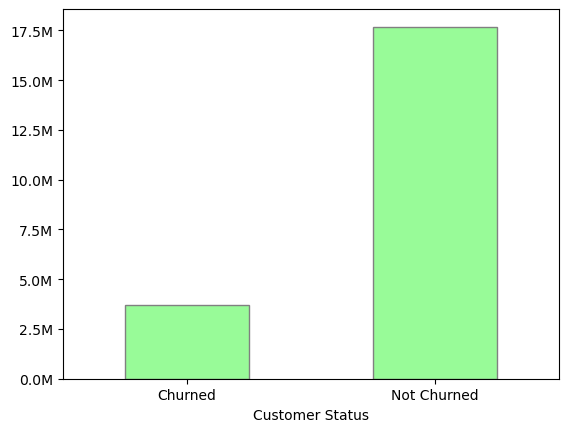

In [18]:
# To see the revenue gained from each customer categories
from matplotlib.ticker import FuncFormatter
df_merge.groupby('Customer Status')['Total Revenue'].sum().plot.bar(color='palegreen', edgecolor = 'grey')
def millions(x, pos):
            return '%1.1fM' % (x * 1e-6)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.xticks(rotation=0)
plt.show()

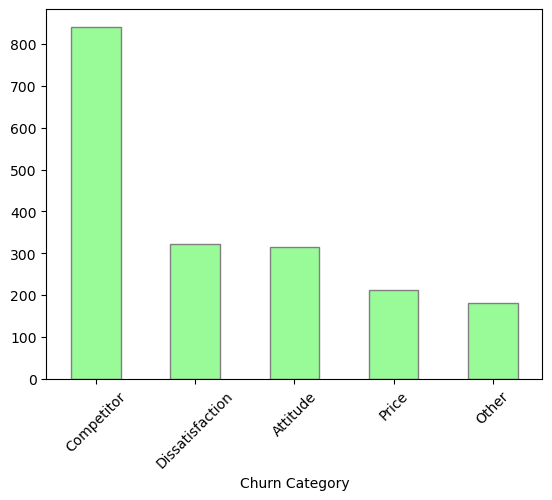

In [19]:
# Churned reasons overview
df_merge['Churn Category'].value_counts().plot.bar(color = 'palegreen',edgecolor = 'grey')
plt.xticks(rotation=45)
plt.show()

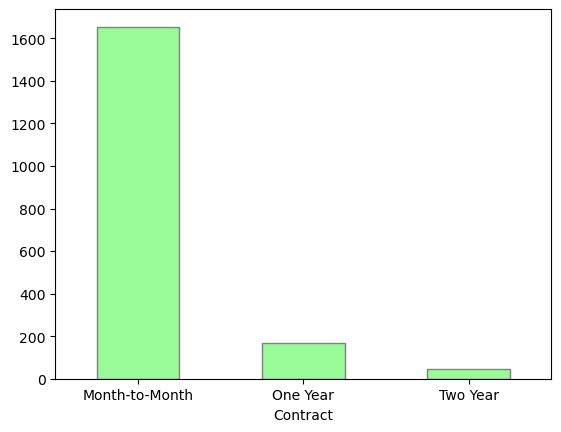

In [20]:
# Number of churned customers in each customer types
dfsub = df_merge[df_merge['Customer Status'] == 'Churned']
dfsub['Contract'].value_counts().plot.bar(color = 'palegreen', edgecolor = 'grey')
plt.xticks(rotation=0)
plt.show()

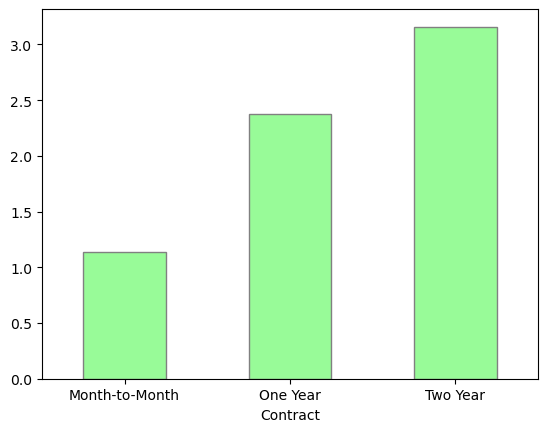

In [21]:
# Average number of referral from the different customer types
df_merge.groupby('Contract')['Number of Referrals'].mean().plot.bar(color = 'palegreen', edgecolor = 'grey')
plt.xticks(rotation=0)
plt.show()

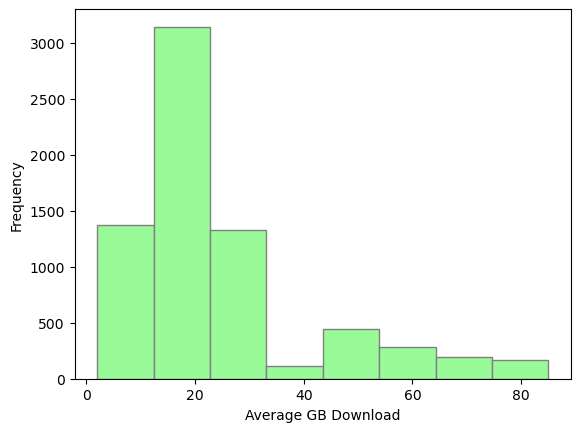

In [22]:
# Distribution of data usage
df_merge['Avg Monthly GB Download'].plot.hist(bins = 8, color = 'palegreen', edgecolor = 'grey')
plt.xlabel('Average GB Download')
plt.ylabel('Frequency')
plt.show()

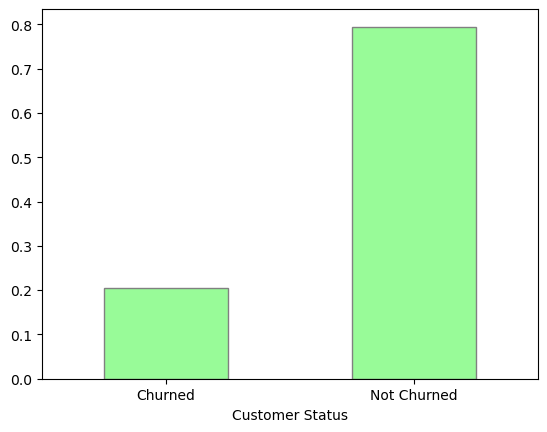

In [23]:
# Proportion of refunds to the customer categories
(df_merge.groupby('Customer Status')['Total Refunds'].sum()/ df_merge['Total Refunds'].sum()).plot.bar(color = 'palegreen', edgecolor = 'grey')
plt.xticks(rotation=0)
plt.show()

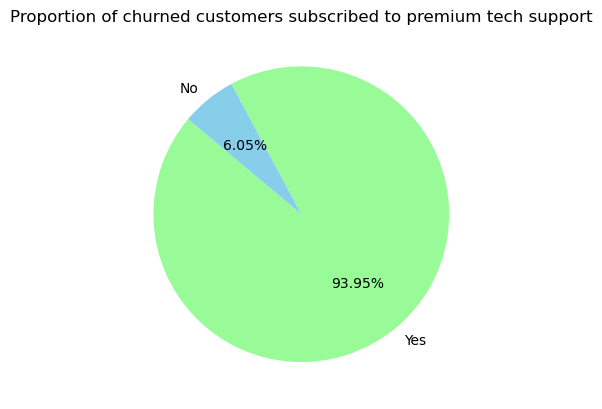

In [24]:
# Proportion of churned customers that have subscribed to premium tech support
dfsub['Premium Tech Support'].value_counts(normalize = True).plot.pie(colors = ['palegreen', 'skyblue'], autopct='%1.2f%%', startangle=140)
plt.title('Proportion of churned customers subscribed to premium tech support')
plt.ylabel('')
plt.show()

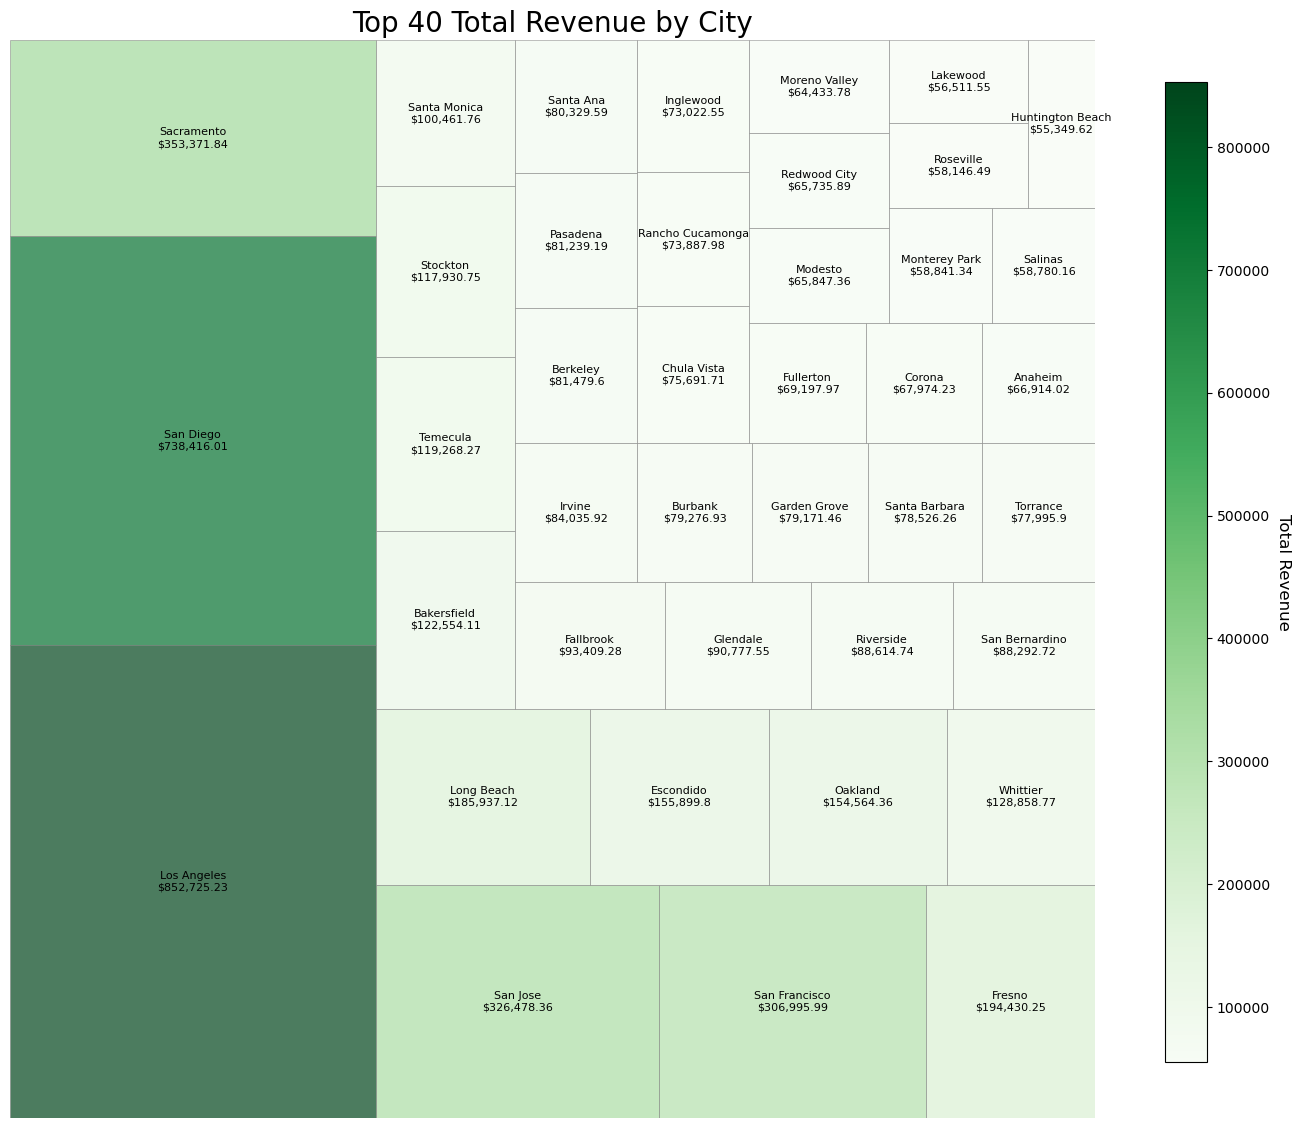

In [25]:
# To see the revenue per city
import squarify
import matplotlib.colors as mcolors

# Group by 'City' and sum 'Total Revenue'
city_revenue = df_merge.groupby('City')['Total Revenue'].sum().round(2).reset_index()

# Optional: Focus on top N cities
top_n = 40 # Adjust as needed
city_revenue = city_revenue.sort_values(by='Total Revenue', ascending=False).head(top_n)

# Create labels
labels = city_revenue.apply(
    lambda x: f"{x['City']}\n${x['Total Revenue']:,}", axis=1
).tolist()

# Sizes for treemap
sizes = city_revenue['Total Revenue'].tolist()

# Choose a colormap
cmap = plt.get_cmap('Greens')  # Change as desired
norm = mcolors.Normalize(vmin=min(sizes), vmax=max(sizes))
colors = [cmap(norm(value)) for value in sizes]

# Set up the figure
fig, ax = plt.subplots(figsize=(14, 14))

# Plot the treemap
squarify.plot(
    sizes=sizes,
    label=labels,
    color=colors,
    alpha=0.7,
    text_kwargs={'fontsize': 8},
    edgecolor='grey',
    linewidth=0.5,
    ax=ax
)

# Remove axes
ax.axis('off')

# Set title
ax.set_title('Top 40 Total Revenue by City', fontsize=20)

# Add a color bar
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only necessary for older matplotlib versions
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Total Revenue', rotation=270, labelpad=15, fontsize=12)

# Adjust layout
plt.subplots_adjust(right=.9)

# Display the plot
plt.show()

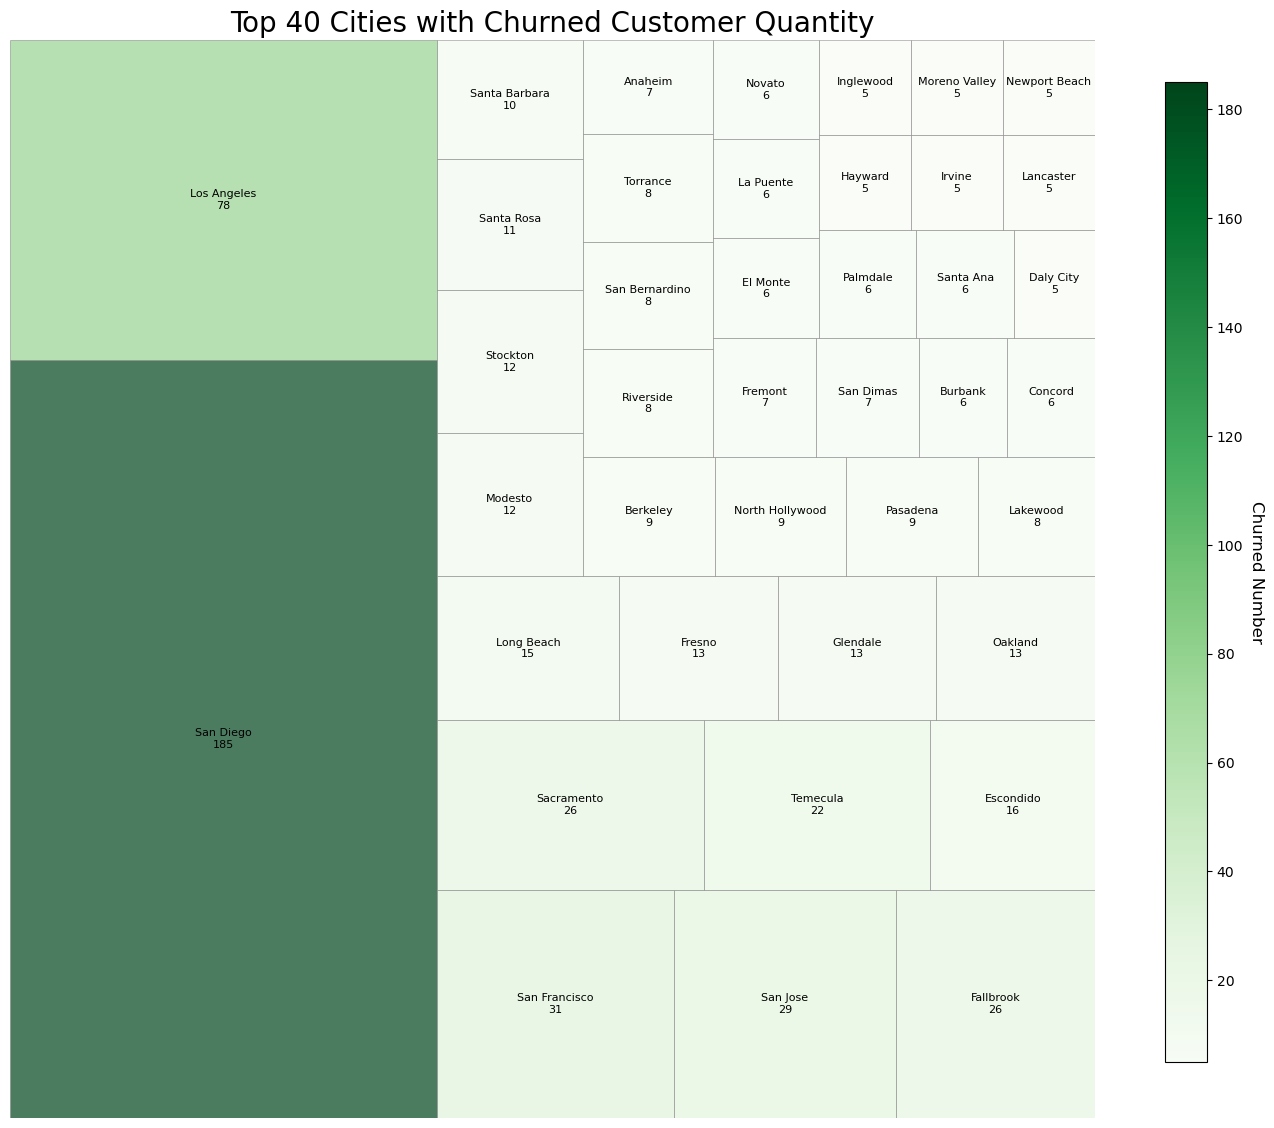

In [26]:
# To see whether the city with high revenue also has high churn number
# Group by 'City' and sum 'Total Revenue'
city_count = df_merge.groupby('City')['Customer Status'].apply(lambda x: (x == 'Churned').sum()).reset_index(name='Churned Count')

# Optional: Focus on top N cities
top_n = 40 # Adjust as needed
city_count = city_count.sort_values(by='Churned Count', ascending=False).head(top_n)

# Create labels
labels = city_count.apply(
    lambda x: f"{x['City']}\n{x['Churned Count']:,}", axis=1
).tolist()

# Sizes for treemap
sizes = city_count['Churned Count'].tolist()

# Choose a colormap
cmap = plt.get_cmap('Greens')  # Change as desired
norm = mcolors.Normalize(vmin=min(sizes), vmax=max(sizes))
colors = [cmap(norm(value)) for value in sizes]

# Set up the figure
fig, ax = plt.subplots(figsize=(14, 14))

# Plot the treemap
squarify.plot(
    sizes=sizes,
    label=labels,
    color=colors,
    alpha=0.7,
    text_kwargs={'fontsize': 8},
    edgecolor='grey',
    linewidth=0.5,
    ax=ax
)

# Remove axes
ax.axis('off')

# Set title
ax.set_title('Top 40 Cities with Churned Customer Quantity', fontsize=20)

# Add a color bar
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only necessary for older matplotlib versions
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('Churned Number', rotation=270, labelpad=15, fontsize=12)

# Adjust layout
plt.subplots_adjust(right=.9)

# Display the plot
plt.show()

<Axes: xlabel='Population', ylabel='Customer Count'>

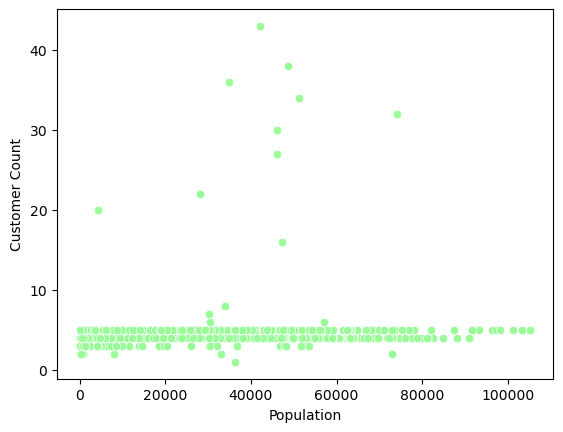

In [27]:
# Correlation of number of user and the population size
customer_no = df_merge.groupby('Zip Code')['Customer ID'].count().rename('Customer Count')
pop = pd.DataFrame(df_merge.groupby('Zip Code')['Population'].unique()).reset_index()
pop['Population'] = pop['Population'].astype('str').str.strip('[]').astype(float)
pop = pd.merge(pop, customer_no.reset_index(), on='Zip Code', how='left')
pop['bins'] = pd.cut(pop['Population'], bins=10, include_lowest=True).astype('str')
sns.scatterplot(x = pop['Population'], y = pop['Customer Count'], color = 'palegreen')

<Axes: xlabel='Total_Customer', ylabel='Churned_Count'>

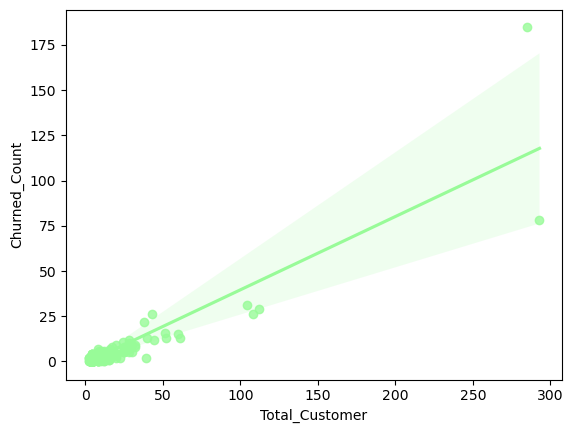

In [28]:
city_count = df_merge.groupby('City').agg(Churned_Count=('Customer Status', lambda x: (x == 'Churned').sum()),
                                          Total_Customer=('Customer Status', 'count')).reset_index()
sns.regplot(city_count, x = 'Total_Customer', y = 'Churned_Count', color='palegreen')

In [29]:
# Proportion of churned customers
print('Proportion of churned customers:', ((df_merge['Customer Status'] == 'Churned').astype('int').sum()/df_merge['Customer Status'].value_counts().sum()).round(3))
revenue = df_merge.groupby('Customer Status')['Total Revenue'].sum()
print('Proportion of churned revenue in the fiscal year:', (revenue['Churned']/df_merge['Total Revenue'].sum()).round(3))

Proportion of churned customers: 0.265
Proportion of churned revenue in the fiscal year: 0.172


In [30]:
# To see whether the company loses any high value customer
valuable = df_merge[['Customer ID', 'Total Revenue', 'Customer Status', 'Churn Reason']].sort_values(by = 'Total Revenue', ascending = False).reset_index(drop = True)
valuable[valuable['Churn Reason'].notna() == True].head(10)

,Customer ID,Total Revenue,Customer Status,Churn Reason
18,2889-FPWRM,11195.44,Churned,Competitor offered higher download speeds
21,3259-FDWOY,11084.84,Churned,Competitor offered higher download speeds
22,2834-JRTUA,11040.97,Churned,Competitor had better devices
44,1984-FCOWB,10756.15,Churned,Attitude of service provider
48,5287-QWLKY,10718.96,Churned,Attitude of support person
49,9835-ZIITK,10717.17,Churned,Competitor made better offer
50,5440-FLBQG,10690.92,Churned,Attitude of service provider
61,9090-SGQXL,10507.21,Churned,Competitor offered more data
72,0979-PHULV,10374.80,Churned,Competitor made better offer
75,3886-CERTZ,10351.16,Churned,Competitor had better devices


#### Findings through EDA：
  - Around 26.54% of the customer churned because of the competitors and poor service quality, and the churned customers contribute to 17.2% of the total revenue of the fiscal year
  - Among all the churned customers, most of them are with short-term contract (Month-to-month contract)
  - Long-term/loyal customers tend to refer more people (May know the service quality through time and get positive  impression)
  - Most of the customers consume around 20 - 30GB data per month on average
  - Most of the customers subscribed to the premium technical support but they still got poor experience on the service support
  - Cities with high revenue does not mean there is large number of churned customers, whcih mean that the revenue and the correlation between revenue and churned customers may not be too strong
  - Number of population and the users are not necessary correlated
  - The company indeed loses valuable customers with whom contribute over 10-thousand dollars each year per customers
  - Recommendation：Regarding the poor expertise for support, on-job training is highly recommended for better user experience (More Advice Below)

### Feature Engineering

In [31]:
df_merge.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 7043 entries, 0 to 7042
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Customer ID                        7043 non-null   object
 1   Gender                             7043 non-null   object
 2   Age                                7043 non-null   int64
 3   Married                            7043 non-null   object
 4   Number of Dependents               7043 non-null   int64
 5   City                               7043 non-null   object
 6   Zip Code                           7043 non-null   int64
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64
 10  Tenure in Months                   7043 non-null   int64
 11  Offer                              7043 non-null   int64
 12  Phone Service  

In [32]:
df_merge['Extra Data Charges'] = np.where(df_merge['Total Extra Data Charges'] != 0, 1, 0)
df_merge['Refunds'] = np.where(df_merge['Total Refunds'] != 0, 1, 0)
df_merge['Long Distance Charges'] = np.where(df_merge['Total Long Distance Charges'] != 0, 1, 0)

In [33]:
columns = ['Phone Service','Multiple Lines', 'Internet Service','Online Security', 'Online Backup',
       'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
       'Streaming Movies', 'Streaming Music', 'Unlimited Data', 
       'Paperless Billing']
for col in columns:
    df_merge[col] = np.where(df_merge[col] == 'Yes', 1, 0)

In [34]:
model_df1 = df_merge.drop(columns = ['Gender', 'Customer ID', 'Age', 'City', 'Married', 'Zip Code', 'Latitude', 'Longitude', 'Population', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason'])

In [35]:
model_df1.columns

Index(['Number of Dependents', 'Number of Referrals', 'Tenure in Months',
       'Offer', 'Phone Service', 'Avg Monthly Long Distance Charges',
       'Multiple Lines', 'Internet Service', 'Internet Type',
       'Avg Monthly GB Download', 'Online Security', 'Online Backup',
       'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
       'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract',
       'Paperless Billing', 'Payment Method', 'Monthly Charge',
       'Extra Data Charges', 'Refunds', 'Long Distance Charges'],
      dtype='object')

In [36]:
model_df1 = pd.get_dummies(model_df1[[#'Online Security', 'Online Backup', 'Device Protection Plan',
                                      'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Extra Data Charges', 'Long Distance Charges']], drop_first = True, dtype = 'int')
model_df1.head()

,Streaming TV,Streaming Movies,Streaming Music,Extra Data Charges,Long Distance Charges
0,1,1,1,0,1
1,1,1,1,1,1
2,1,1,1,0,1
3,1,1,1,0,1
4,1,1,1,0,1


In [37]:
model_df1.columns

Index(['Streaming TV', 'Streaming Movies', 'Streaming Music',
       'Extra Data Charges', 'Long Distance Charges'],
      dtype='object')

### Unsupervised Learning

#### 1. Clustering (Customer Segmentation)

In [38]:
from cuml.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(model_df1)
df_scaled.head()

,0,1,2,3,4
0,0.525927,0.525927,0.525927,-0.339531,0.327438
1,0.525927,0.525927,0.525927,2.945242,0.327438
2,0.525927,0.525927,0.525927,-0.339531,0.327438
3,0.525927,0.525927,0.525927,-0.339531,0.327438
4,0.525927,0.525927,0.525927,-0.339531,0.327438


In [39]:
from cuml.cluster import KMeans

kmeans3 = KMeans(n_clusters=3, random_state=42)
kmeans3.fit(df_scaled)

KMeans()

In [40]:
kmeans3.labels_.value_counts()

0    4835
1    1526
2     682
Name: count, dtype: int64

In [41]:
cluster_centers3 = pd.DataFrame(cp.asnumpy(kmeans3.cluster_centers_), columns = model_df1.columns)
cluster_centers3

,Streaming TV,Streaming Movies,Streaming Music,Extra Data Charges,Long Distance Charges
0,0.525927,0.525927,0.525927,0.087795,0.327438
1,-1.901403,-1.901403,-1.901403,-0.339531,0.327438
2,0.525927,0.525927,0.525927,0.137291,-3.054010


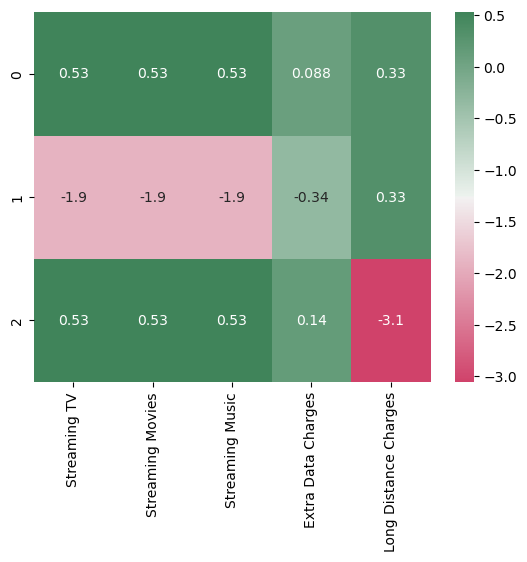

In [42]:
sns.heatmap(cp.asnumpy(cluster_centers3), xticklabels = model_df1.columns, cmap = sns.diverging_palette(0, 140, s=70, as_cmap=True), annot = True);

In [43]:
## Cluster 0: Entertainment enthuasiasts with long distance service
## Cluster 1: Non-entertainment users with long distance service
## Cluster 2: Entertainment enthuasiasts without long distance service

In [44]:
kmeans3.inertia_

6816.957732490843

In [45]:
# fit k-means models for 2-15 clusters, note the inertia scores
inertia_values = []

for k in range(2, 11): # end point should be n-1
    kmeans = KMeans(n_clusters = k, n_init = 10, random_state = 42)
    kmeans.fit(model_df1)
    inertia_values.append(kmeans.inertia_)

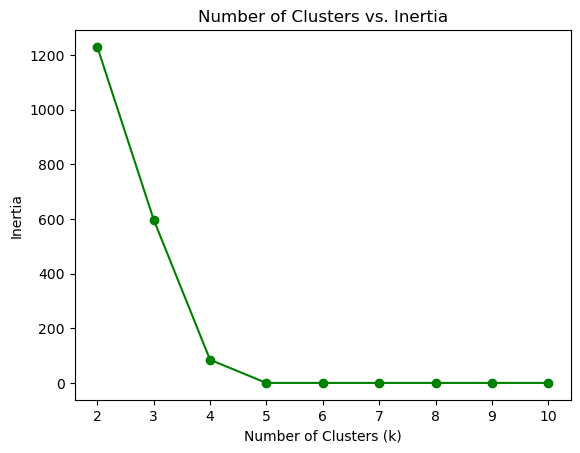

In [46]:
# plot the inertia values
import matplotlib.pyplot as plt

# turn the list into a series for plotting
inertia_series = pd.Series(inertia_values, index = range(2, 11))

# plot the data
inertia_series.plot(marker='o', color = 'green')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Number of Clusters vs. Inertia");

In [47]:
# elbow at k = 4

In [48]:
kmeans4 = KMeans(n_clusters=4, random_state=42)
kmeans4.fit(df_scaled)

KMeans()

In [49]:
kmeans4.labels_.value_counts()

2    4835
1    1526
0     583
3      99
Name: count, dtype: int64

In [50]:
cluster_centers4 = pd.DataFrame(cp.asnumpy(kmeans4.cluster_centers_), columns = model_df1.columns)
cluster_centers4

,Streaming TV,Streaming Movies,Streaming Music,Extra Data Charges,Long Distance Charges
0,0.525927,0.525927,0.525927,-0.339531,-3.054010
1,-1.901403,-1.901403,-1.901403,-0.339531,0.327438
2,0.525927,0.525927,0.525927,0.087795,0.327438
3,0.525927,0.525927,0.525927,2.945242,-3.054010


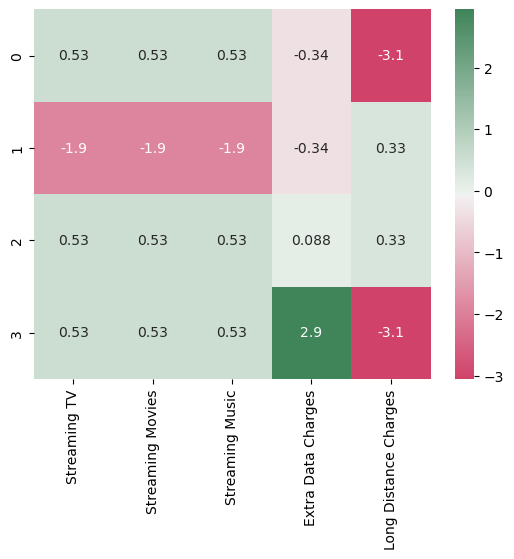

In [51]:
sns.heatmap(cp.asnumpy(cluster_centers4), xticklabels = model_df1.columns, cmap = sns.diverging_palette(0, 140, s=70, as_cmap=True), annot = True);

In [52]:
## Cluster 0: Entertainment enthuasiasts without long distance line service
## Cluster 1: Non-entertainment users with long distance line service
## cluster 2: Entertainment enthuasiasts with long distance line service
## Cluster 3: Heavy data usage customers without long distance line service

In [53]:
kmeans4.inertia_

5903.833186636921

#### 2. Select the Best K-Means Model

In [54]:
model1_clusters = pd.Series(kmeans3.labels_, name='model1_clusters')
model1_names = model1_clusters.map({0: 'Entertainment enthuasiasts with long distance service',
                                    1: 'Non-entertainment users with long distance service',
                                    2: 'Entertainment enthuasiasts without long distance service'})
model1_names.head()

0    Entertainment enthuasiasts with long distance ...
1    Entertainment enthuasiasts with long distance ...
2    Entertainment enthuasiasts with long distance ...
3    Entertainment enthuasiasts with long distance ...
4    Entertainment enthuasiasts with long distance ...
Name: model1_clusters, dtype: object

In [55]:
model2_clusters = pd.Series(kmeans4.labels_, name='model2_clusters')
model2_names = model2_clusters.map({0: 'Entertainment enthuasiasts without long distance service',
                                    1: 'Non-entertainment users with long distance service',
                                    2: 'Entertainment enthuasiasts with long distance service',
                                    3: 'Heavy data usage customers without long distance service',})
model2_names.head()

0    Entertainment enthuasiasts with long distance ...
1    Entertainment enthuasiasts with long distance ...
2    Entertainment enthuasiasts with long distance ...
3    Entertainment enthuasiasts with long distance ...
4    Entertainment enthuasiasts with long distance ...
Name: model2_clusters, dtype: object

In [56]:
cluster_names = pd.concat([model_df1, model1_names, model2_names], axis = 1)
cluster_names.head()

,Streaming TV,Streaming Movies,Streaming Music,Extra Data Charges,Long Distance Charges,model1_clusters,model2_clusters
0,1,1,1,0,1,Entertainment enthuasiasts with long distance ...,Entertainment enthuasiasts with long distance ...
1,1,1,1,1,1,Entertainment enthuasiasts with long distance ...,Entertainment enthuasiasts with long distance ...
2,1,1,1,0,1,Entertainment enthuasiasts with long distance ...,Entertainment enthuasiasts with long distance ...
3,1,1,1,0,1,Entertainment enthuasiasts with long distance ...,Entertainment enthuasiasts with long distance ...
4,1,1,1,0,1,Entertainment enthuasiasts with long distance ...,Entertainment enthuasiasts with long distance ...


In [57]:
(cluster_names.groupby(['model1_clusters', 'model2_clusters'])[['Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Extra Data Charges', 'Long Distance Charges']].mean())

Streaming TV  \
model1_clusters                                    model2_clusters                                                    
Entertainment enthuasiasts with long distance s... Entertainment enthuasiasts with long distance s...           1.0   
Entertainment enthuasiasts without long distanc... Entertainment enthuasiasts without long distanc...           1.0   
                                                   Heavy data usage customers without long distanc...           1.0   
Non-entertainment users with long distance service Non-entertainment users with long distance service           0.0   

                                                                                                       Streaming Movies  \
model1_clusters                                    model2_clusters                                                        
Entertainment enthuasiasts with long distance s... Entertainment enthuasiasts with long distance s...               1.0   
Entertainment enthuasiasts without long distanc... Entertainment enthuasiasts without long distanc...               1.0   
                                                   Heavy data usage customers without long distanc...               1.0   
Non-entertainment users with long distance service Non-entertainment users with long distance service               0.0   

                                                                                                       Streaming Music  \
model1_clusters                                    model2_clusters                                                       
Entertainment enthuasiasts with long distance s... Entertainment enthuasiasts with long distance s...              1.0   
Entertainment enthuasiasts without long distanc... Entertainment enthuasiasts without long distanc...              1.0   
                                                   Heavy data usage customers without long distanc...              1.0   
Non-entertainment users with long distance service Non-entertainment users with long distance service              0.0   

                                                                                                       Extra Data Charges  \
model1_clusters                                    model2_clusters                                                          
Entertainment enthuasiasts with long distance s... Entertainment enthuasiasts with long distance s...            0.130093   
Entertainment enthuasiasts without long distanc... Entertainment enthuasiasts without long distanc...            0.000000   
                                                   Heavy data usage customers without long distanc...            1.000000   
Non-entertainment users with long distance service Non-entertainment users with long distance service            0.000000   

                                                                                                       Long Distance Charges  
model1_clusters                                    model2_clusters                                                            
Entertainment enthuasiasts with long distance s... Entertainment enthuasiasts with long distance s...                    1.0  
Entertainment enthuasiasts without long distanc... Entertainment enthuasiasts without long distanc...                    0.0  
                                                   Heavy data usage customers without long distanc...                    0.0  
Non-entertainment users with long distance service Non-entertainment users with long distance service                    1.0

* Model 2 with 4 clusters better segment the customers, so model 2 (4 clusters one) is chosen. Customer segmentation as below:
  - Cluster 0: Entertainment enthuasiasts without long distance line service
  - Cluster 1: Non-entertainment users with long distance line service
  - Cluster 2: Entertainment enthuasiasts with long distance line service
  - Cluster 3: Heavy data usage customers without long distance line service

**Original Goal**: Help reducing churned customers

**Recommendation**: Provide value-added service for each customer profile below:
* Entertainment enthuasiasts without long distance service: Provide offers with combination of more diverse free entertainment platforms access
* Non-entertainment users with long distance service: Provide offers with free long-distance service limit for each month
* Entertainment enthuasiasts with long distance service: Suggest customers upgrading to taylor-made plan for unlimited service assess without significant price boost
* Heavy data usage customers without long distance service: Provide offers with data-oriented package for customers

#### 3. DBScan

In [58]:
df_merge.columns

Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason',
       'Population', 'Extra Data Charges', 'Refunds', 'Long Distance Charges'],
      dtype='object')

In [59]:
model_df2 = pd.get_dummies(df_merge[['Tenure in Months', 'Avg Monthly GB Download', 'Multiple Lines',
                                     'Premium Tech Support', 'Online Security', 'Online Backup', 'Device Protection Plan',
                                     'Streaming TV', 'Streaming Movies','Streaming Music', 'Unlimited Data', 'Contract', 
                                     'Monthly Charge', 'Total Charges', 'Total Revenue'
                                    ]], drop_first = True, dtype = 'int')

scaler = StandardScaler()
df2_scaled = scaler.fit_transform(model_df2)
df2_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.952994,-0.519061,-0.854176,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.064221,-0.744500,-0.718872,1.882517,-0.604088
1,-0.952994,-0.862603,1.170719,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,-2.166367,-0.766962,-0.846108,-0.531204,-0.604088
2,-1.156740,0.282537,-0.854176,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.330225,-0.882382,-0.914111,-0.531204,-0.604088
3,-0.789997,-1.206146,-0.854176,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,1.102599,-0.460063,-0.500827,-0.531204,-0.604088
4,-1.197489,-0.805346,-0.854176,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.650712,-0.888318,-0.958059,-0.531204,-0.604088


In [60]:
pd.get_dummies(df_merge[['Tenure in Months', 'Avg Monthly GB Download', 'Multiple Lines', 
                                     'Premium Tech Support', 'Online Security', 'Online Backup', 'Device Protection Plan',
                                     'Streaming TV', 'Streaming Movies','Streaming Music', 'Unlimited Data', 'Contract', 
                                     'Monthly Charge', 'Total Charges', 'Total Revenue'
                                    ]], drop_first = True, dtype = 'int').columns

Index(['Tenure in Months', 'Avg Monthly GB Download', 'Multiple Lines',
       'Premium Tech Support', 'Online Security', 'Online Backup',
       'Device Protection Plan', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Monthly Charge', 'Total Charges',
       'Total Revenue', 'Contract_One Year', 'Contract_Two Year'],
      dtype='object')

In [61]:
df2_scaled.columns = pd.get_dummies(df_merge[['Tenure in Months', 'Avg Monthly GB Download', 'Multiple Lines', 
                                     'Premium Tech Support', 'Online Security', 'Online Backup', 'Device Protection Plan',
                                     'Streaming TV', 'Streaming Movies','Streaming Music', 'Unlimited Data', 'Contract', 
                                     'Monthly Charge', 'Total Charges', 'Total Revenue'
                                    ]], drop_first = True, dtype = 'int').columns

In [62]:
df2_scaled

,Tenure in Months,Avg Monthly GB Download,Multiple Lines,Premium Tech Support,Online Security,Online Backup,Device Protection Plan,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Monthly Charge,Total Charges,Total Revenue,Contract_One Year,Contract_Two Year
0,-0.952994,-0.519061,-0.854176,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.064221,-0.744500,-0.718872,1.882517,-0.604088
1,-0.952994,-0.862603,1.170719,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,-2.166367,-0.766962,-0.846108,-0.531204,-0.604088
2,-1.156740,0.282537,-0.854176,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.330225,-0.882382,-0.914111,-0.531204,-0.604088
3,-0.789997,-1.206146,-0.854176,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,1.102599,-0.460063,-0.500827,-0.531204,-0.604088
4,-1.197489,-0.805346,-0.854176,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.650712,-0.888318,-0.958059,-0.531204,-0.604088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.789997,1.942991,-0.854176,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,-0.270687,-0.678482,-0.588006,1.882517,-0.604088
7039,-0.423253,-0.461804,1.170719,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.689171,-0.179466,-0.280726,-0.531204,-0.604088
7040,-1.238238,1.484935,-0.854176,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,-0.426124,-0.965390,-1.013748,-0.531204,-0.604088
7041,1.410464,1.885734,-0.854176,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.136331,1.035837,0.605693,-0.531204,1.655388


In [63]:
from cuml.cluster import DBSCAN
from sklearn.metrics import silhouette_score

def tune_dbscan(data):

    results = []

    # define a range of eps and min_samples values to loop through
    eps_values = np.arange(.1, 2, .1)
    min_samples_values = np.arange(2, 10, 1)

    # loop through the combinations of eps and min_samples
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan.fit(data)
            labels = dbscan.labels_

            # count the number of clusters (excluding noise points labeled as -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            # count the number of noise points (labeled as -1)
            n_noise = list(labels).count(-1)

            # calculate the silhouette score (excluding noise points)
            if n_clusters > 1:  # silhouette score requires at least 2 clusters
                silhouette = silhouette_score(data, labels, metric='euclidean', sample_size=None)
            else:
                silhouette = None

            results.append([eps, min_samples, n_clusters, n_noise, silhouette])

    # put the results in a dataframe
    dbscan_results = pd.DataFrame(results, columns=['Eps', 'Min Samples', 'Number of Clusters',
                                                    'Number of Noise Points', 'Silhouette Score'])
    return dbscan_results

In [64]:
dbscan_results = tune_dbscan(df2_scaled)
dbscan_results.head()

,Eps,Min Samples,Number of Clusters,Number of Noise Points,Silhouette Score
0,0.1,2,374,4591,-0.385016
1,0.1,3,131,5077,-0.239832
2,0.1,4,69,5329,-0.222788
3,0.1,5,56,5428,-0.183712
4,0.1,6,50,5556,-0.192117


In [65]:
(dbscan_results.sort_values('Silhouette Score', ascending = False).groupby('Silhouette Score').head(1)).head()

,Eps,Min Samples,Number of Clusters,Number of Noise Points,Silhouette Score
144,1.9,2,14,3,0.373248
149,1.9,7,14,7,0.373099
146,1.9,4,14,5,0.373016
134,1.7,8,14,20,0.372821
143,1.8,9,14,17,0.372766


In [66]:
dbscan = DBSCAN(eps = 1.9, min_samples = 7)

In [67]:
dbscan.fit(df2_scaled)

DBSCAN()

In [68]:
df2_scaled['anomaly_dbscan'] = dbscan.labels_

In [69]:
dbscan.labels_.value_counts()

 2     1790
 1     1301
 4      730
 0      598
 5      584
 3      496
 7      472
 8      410
 9      302
 10     232
 6       64
 11      46
 12      11
-1        7
Name: count, dtype: int64

In [70]:
df2_scaled['anomaly_dbscan']

0       0
1       1
2       2
3       2
4       2
       ..
7038    0
7039    1
7040    2
7041    3
7042    3
Name: anomaly_dbscan, Length: 7043, dtype: int32

In [71]:
df2_scaled = pd.concat([df2_scaled, df_merge['Customer Status']], axis = 1)

In [72]:
outlier = df2_scaled[df2_scaled['anomaly_dbscan'] == -1].index

In [73]:
df2_scaled = df2_scaled[~df2_scaled.index.isin(outlier)].drop(columns = 'anomaly_dbscan').reset_index(drop=True)

In [74]:
df2_scaled.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 7036 entries, 0 to 7035
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Tenure in Months         7036 non-null   float64
 1   Avg Monthly GB Download  7036 non-null   float64
 2   Multiple Lines           7036 non-null   float64
 3   Premium Tech Support     7036 non-null   float64
 4   Online Security          7036 non-null   float64
 5   Online Backup            7036 non-null   float64
 6   Device Protection Plan   7036 non-null   float64
 7   Streaming TV             7036 non-null   float64
 8   Streaming Movies         7036 non-null   float64
 9   Streaming Music          7036 non-null   float64
 10  Unlimited Data           7036 non-null   float64
 11  Monthly Charge           7036 non-null   float64
 12  Total Charges            7036 non-null   float64
 13  Total Revenue            7036 non-null   float64
 14  Contract_One Year        7

In [75]:
df2_scaled.tail()

,Tenure in Months,Avg Monthly GB Download,Multiple Lines,Premium Tech Support,Online Security,Online Backup,Device Protection Plan,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Monthly Charge,Total Charges,Total Revenue,Contract_One Year,Contract_Two Year,Customer Status
7031,-0.789997,1.942991,-0.854176,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,-0.270687,-0.678482,-0.588006,1.882517,-0.604088,Not Churned
7032,-0.423253,-0.461804,1.170719,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.689171,-0.179466,-0.280726,-0.531204,-0.604088,Churned
7033,-1.238238,1.484935,-0.854176,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,-0.426124,-0.965390,-1.013748,-0.531204,-0.604088,Not Churned
7034,1.410464,1.885734,-0.854176,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.136331,1.035837,0.605693,-0.531204,1.655388,Not Churned
7035,1.247467,-1.148889,-0.854176,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,0.525927,-0.147300,0.629824,0.234981,-0.531204,1.655388,Not Churned


#### 4. PCA

In [76]:
df2_scaled['Customer Status'] = np.where(df2_scaled['Customer Status'] == 'Not Churned', 0, 1)

In [77]:
data_centered = df2_scaled.drop(columns = 'Customer Status') - df2_scaled.drop(columns = 'Customer Status').mean()
data_centered.head()

,Tenure in Months,Avg Monthly GB Download,Multiple Lines,Premium Tech Support,Online Security,Online Backup,Device Protection Plan,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Monthly Charge,Total Charges,Total Revenue,Contract_One Year,Contract_Two Year
0,-0.952355,-0.517641,-0.854163,0.526451,0.526451,0.526451,0.526451,0.526451,0.526451,0.526451,0.526451,0.061970,-0.743544,-0.717779,1.882675,-0.603405
1,-0.952355,-0.861183,1.170732,0.526451,0.526451,0.526451,0.526451,0.526451,0.526451,0.526451,0.526451,-2.168618,-0.766006,-0.845015,-0.531046,-0.603405
2,-1.156101,0.283958,-0.854163,0.526451,0.526451,0.526451,0.526451,0.526451,0.526451,0.526451,0.526451,0.327975,-0.881426,-0.913018,-0.531046,-0.603405
3,-0.789358,-1.204725,-0.854163,0.526451,0.526451,0.526451,0.526451,0.526451,0.526451,0.526451,0.526451,1.100348,-0.459107,-0.499734,-0.531046,-0.603405
4,-1.196850,-0.803926,-0.854163,0.526451,0.526451,0.526451,0.526451,0.526451,0.526451,0.526451,0.526451,0.648461,-0.887362,-0.956966,-0.531046,-0.603405


In [78]:
from cuml.decomposition import PCA

pca = PCA(n_components = 3)
pca.fit(data_centered)

PCA()

In [150]:
# View and interpret the explained variance ratios
print(f'Variance explained by PCs:\n{pca.explained_variance_ratio_}')
print(f'Total variance explained: {pca.explained_variance_ratio_.sum():.3%}')
# 56.53% of the variance of data points are correctly predicted by 1 PCA while 
# 76.03% of variance of the data points are correctly predicted by 2 PCA, and so on.
# There is a loss 16.05% of confidence.

Variance explained by PCs:
0    0.565300
1    0.195098
2    0.079125
dtype: float64
Total variance explained: 83.952%


In [80]:
pd.DataFrame(cp.asnumpy(pca.components_), 
                                columns = pd.get_dummies(df_merge[['Tenure in Months', 'Avg Monthly GB Download', 'Multiple Lines',
                                     'Premium Tech Support', 'Online Security', 'Online Backup', 'Device Protection Plan',
                                     'Streaming TV', 'Streaming Movies','Streaming Music', 'Unlimited Data', 'Contract', 
                                     'Monthly Charge', 'Total Charges', 'Total Revenue'
                                    ]], drop_first = True, dtype = 'int').columns)

,Tenure in Months,Avg Monthly GB Download,Multiple Lines,Premium Tech Support,Online Security,Online Backup,Device Protection Plan,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Monthly Charge,Total Charges,Total Revenue,Contract_One Year,Contract_Two Year
0,0.055375,0.045520,0.104529,0.327757,0.327757,0.327757,0.327757,0.327757,0.327757,0.327757,0.327757,0.268699,0.171244,0.145794,0.002026,-0.041882
1,0.515880,0.003197,0.270865,-0.087669,-0.087669,-0.087669,-0.087669,-0.087669,-0.087669,-0.087669,-0.087669,0.138196,0.463078,0.486420,0.079269,0.350110
2,0.046905,0.061164,0.000138,-0.024485,-0.024485,-0.024485,-0.024485,-0.024485,-0.024485,-0.024485,-0.024485,0.028887,0.080787,0.087292,0.823136,-0.544729


* PC1: higher = more likely to have more entertainment and subscribe to additional services (high-value, multi-service subscribers)
* PC2: higher = higher tenure in months and more service charges on customers and more company revenue but less add-ons (long-tenured, higher total revenue, but fewer add-ons)
* PC3: higher = customers is more likely to have one year contract

In [81]:
df_pca = pd.DataFrame(cp.asnumpy(pca.transform(data_centered)), 
                                columns = ['PC1', 'PC2', 'PC3'])

df_pca.head()

,PC1,PC2,PC3
0,1.028561,-1.840460,1.577885
1,0.597942,-1.864969,-0.507025
2,1.068277,-2.256397,-0.389961
3,1.360930,-1.568626,-0.371308
4,1.095191,-2.260732,-0.453470


In [82]:
df_pca = pd.concat([df_pca, df2_scaled['Customer Status']], axis = 1)

#### 5. T-SNE

In [83]:
from cuml.manifold import TSNE

In [84]:
tsne = TSNE(n_components = 2, random_state = 42)

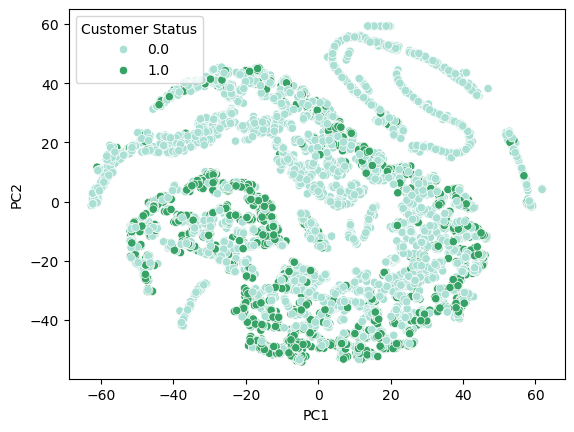

In [85]:
data_tsne = tsne.fit_transform(df_pca.drop(columns = ['PC3', 'Customer Status']))
df_tsne1 = pd.DataFrame(cp.array(pd.concat([data_tsne, df2_scaled['Customer Status']], axis = 1)), columns = ['PC1', 'PC2', 'Customer Status'])
sns.scatterplot(data = df_tsne1, x = 'PC1', y = 'PC2', hue = 'Customer Status', palette = 'BuGn');

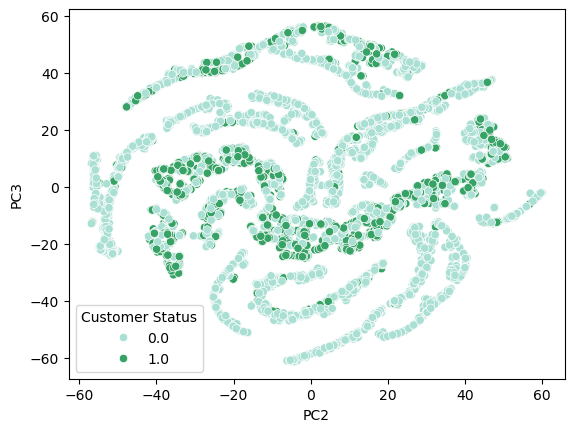

In [86]:
data_tsne = tsne.fit_transform(df_pca.drop(columns = ['PC1', 'Customer Status']))
df_tsne2 = pd.DataFrame(cp.array(pd.concat([data_tsne, df2_scaled['Customer Status']], axis = 1)), columns = ['PC2', 'PC3', 'Customer Status'])
sns.scatterplot(data = df_tsne2, x = 'PC2', y = 'PC3', hue = 'Customer Status', palette = 'BuGn');

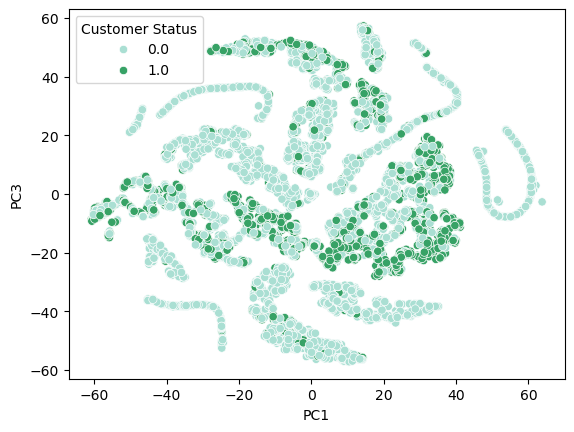

In [87]:
data_tsne = tsne.fit_transform(df_pca.drop(columns = ['PC2', 'Customer Status']))
df_tsne3 = pd.DataFrame(cp.array(pd.concat([data_tsne, df2_scaled['Customer Status']], axis = 1)), columns = ['PC1', 'PC3', 'Customer Status'])
sns.scatterplot(data = df_tsne3, x = 'PC1', y = 'PC3', hue = 'Customer Status', palette = 'BuGn');

* There is no perfect class separation for the T-SNE plots, this may indicate there may be non-linear relationship between PCs.

### Supervised Learning

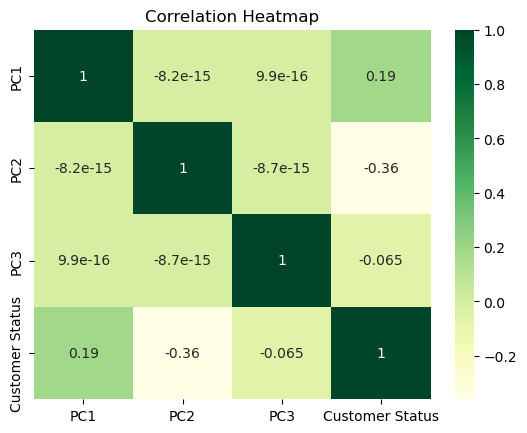

In [88]:
# Correlation Matrix
sns.heatmap(cp.asnumpy(df_pca.corr(numeric_only = True)), xticklabels = df_pca.columns, yticklabels = df_pca.columns, cmap='YlGn', annot=True)
plt.title('Correlation Heatmap')
plt.show()

#### KNN

In [89]:
X = pd.get_dummies(df_pca.drop(columns = 'Customer Status'), drop_first = True)
y = df_pca['Customer Status']

from cuml import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y, random_state = 42)

In [90]:
from cuml.neighbors import KNeighborsClassifier
k = 2
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [91]:
print(f'Train accuracy: {knn.score(X_train, y_train):.3%}')
print(f'Test accuracy: {knn.score(X_test, y_test):.3%}')

Train accuracy: 87.120%
Test accuracy: 79.033%


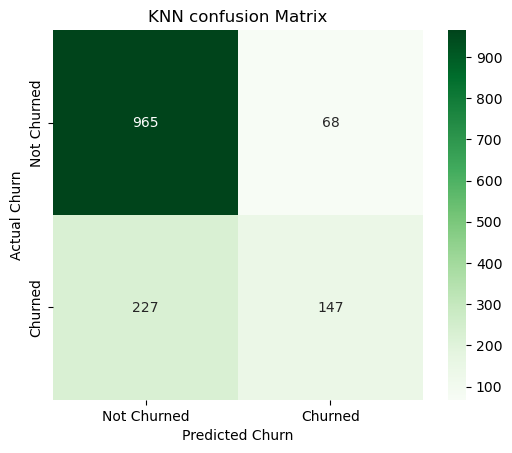

In [92]:
from cuml.metrics import confusion_matrix

y_pred = knn.predict(X_test)

knn_confusion = confusion_matrix(y_test, y_pred)

sns.heatmap(
    knn_confusion.get(),
    cmap = 'Greens',
    annot = True,
    fmt = 'g',
    square = True,
    xticklabels = ['Not Churned', 'Churned'],
    yticklabels = ['Not Churned', 'Churned']
).set(
    ylabel = 'Actual Churn',
    xlabel = 'Predicted Churn',
    title = 'KNN confusion Matrix'
);

In [93]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'Test precision: {precision_score(y_test.to_numpy(), y_pred.to_numpy()):.3%}')
print(f'Test recall: {recall_score(y_test.to_numpy(), y_pred.to_numpy()):.3%}')
print(f'Test F1-score: {f1_score(y_test.to_numpy(), y_pred.to_numpy()):.3%}')

Test precision: 68.372%
Test recall: 39.305%
Test F1-score: 49.915%


In [94]:
# from cuml.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold

# parameters = {'n_neighbors': range(15, 51, 5), 'metric': ['minkowski', 'manhattan', 'uniform']}

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# gridsearch = GridSearchCV(estimator=KNeighborsClassifier(),
#     param_grid=parameters,
#     cv=cv,
#     verbose=2,
#     n_jobs=-1)

# gridsearch.fit(X_train.to_numpy(), y_train.to_numpy())

# gridsearch.best_params_

In [95]:
knn_tuned = knn = KNeighborsClassifier(n_neighbors=45, metric='manhattan')
knn_tuned.fit(X_train, y_train)

print(f'Train accuracy: {knn_tuned.score(X_train, y_train):.3%}')
print(f'Test accuracy: {knn_tuned.score(X_test, y_test):.3%}')

Train accuracy: 80.600%
Test accuracy: 81.308%


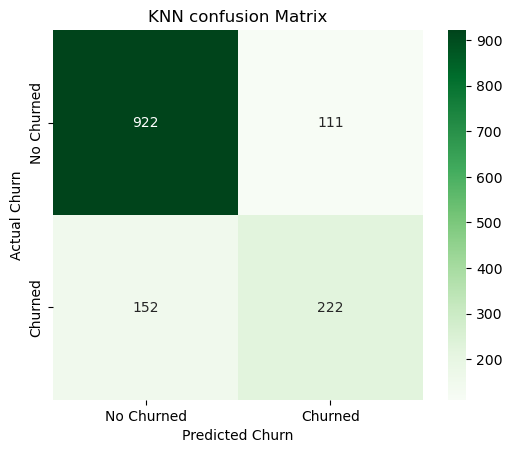

In [96]:
y_pred = knn_tuned.predict(X_test)

knn_confusion = confusion_matrix(y_test, y_pred)

sns.heatmap(
    knn_confusion.get(),
    cmap = 'Greens',
    annot = True,
    fmt = 'g',
    square = True,
    xticklabels = ['No Churned', 'Churned'],
    yticklabels = ['No Churned', 'Churned']
).set(
    ylabel = 'Actual Churn',
    xlabel = 'Predicted Churn',
    title = 'KNN confusion Matrix'
);

In [97]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

print(f'Test precision score: {precision_score(y_test.to_numpy(), y_pred.to_numpy()):.3%}')
print(f'Test recall score: {recall_score(y_test.to_numpy(), y_pred.to_numpy()):.3%}')
print(f'Test F1-score: {f1_score(y_test.to_numpy(), y_pred.to_numpy()):.3%}')

Test precision score: 66.667%
Test recall score: 59.358%
Test F1-score: 62.801%


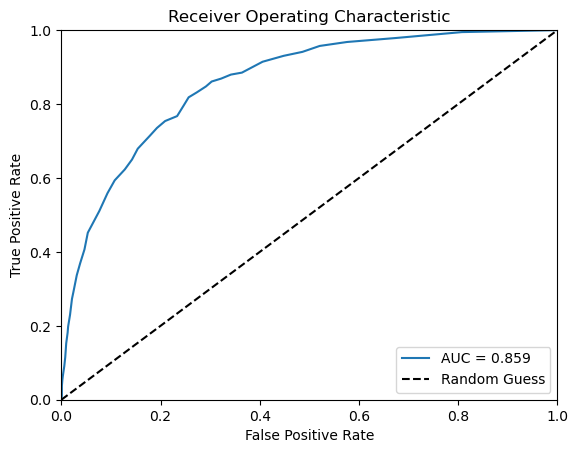

In [98]:
# calculate the fpr and tpr for all thresholds of the classification
probs = knn_tuned.predict_proba(X_test).iloc[:,1].to_numpy()
fpr, tpr, threshold = roc_curve(y_test.to_numpy(), probs)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'k--', label="Random Guess")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

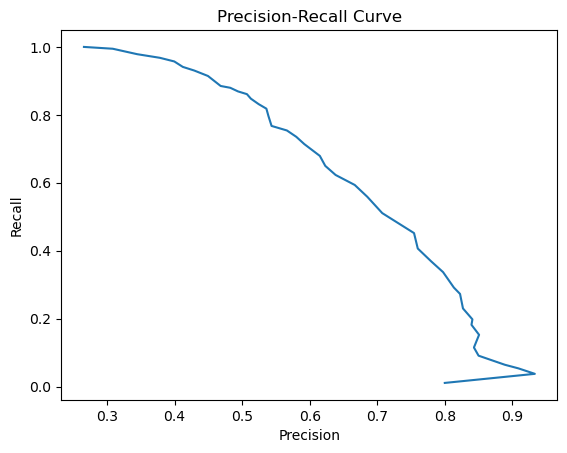

In [99]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

p_curve, r_curve, t_curve = precision_recall_curve(y_test.to_numpy(), knn_tuned.predict_proba(X_test).iloc[:, 1].to_numpy())

plt.plot(p_curve[:-1], r_curve[:-1], label='Precision-Recall Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')
# plt.legend()
plt.show()

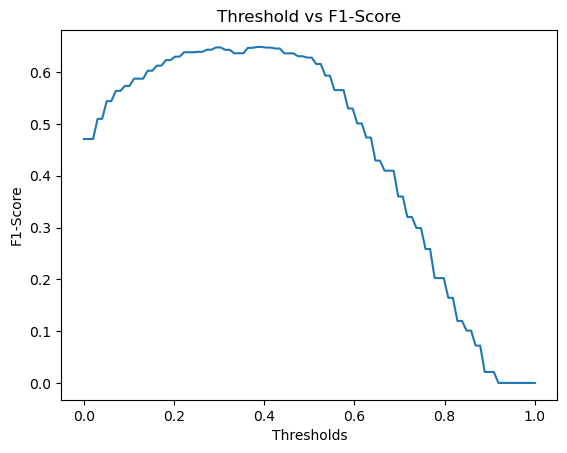

In [100]:
f1 = []
recall = []
precision = []

thresholds = np.linspace(0, 1, 100)

for thresh in thresholds:
    y_pred = (knn_tuned.predict_proba(X_test).iloc[:, 1].to_numpy() > thresh)
    recall.append(recall_score(y_test.to_numpy(), y_pred))
    precision.append(precision_score(y_test.to_numpy(), y_pred))
    f1.append(f1_score(y_test.to_numpy(), y_pred))
    
sns.lineplot(x = thresholds, y = f1)
plt.xlabel('Thresholds')
plt.ylabel('F1-Score')
plt.title('Threshold vs F1-Score')
plt.show()

In [101]:
thresh = thresholds[f1.index(max(f1))]
thresh

0.38383838383838387

In [102]:
metrics = pd.DataFrame({'Precision': precision,
             'Recall': recall,
             'F1-Score': f1}).sort_values('F1-Score', ascending = False)
metrics

,Precision,Recall,F1-Score
38,0.580169,0.735294,0.648585
39,0.580169,0.735294,0.648585
29,0.535902,0.818182,0.647619
30,0.535902,0.818182,0.647619
40,0.592018,0.713904,0.647273
...,...,...,...
95,0.000000,0.000000,0.000000
96,0.000000,0.000000,0.000000
97,0.000000,0.000000,0.000000
98,0.000000,0.000000,0.000000


#### Logistic Regression

In [103]:
from cuml.linear_model import LogisticRegression

lr = LogisticRegression()
lr = lr.fit(X_train, y_train)

In [104]:
pd.DataFrame(lr.coef_.to_numpy(), columns = df_pca.drop(columns = 'Customer Status').columns)

,PC1,PC2,PC3
0,0.221613,-0.549782,-0.108749


In [105]:
lr.intercept_.reset_index(name = 'Intercept').drop(columns = 'index')

,Intercept
0,-1.32868


In [106]:
print(f'Train accuracy: {lr.score(X_train, y_train):.3%}')
print(f'Test accuracy: {lr.score(X_test, y_test):.3%}')

Train accuracy: 75.786%
Test accuracy: 76.119%


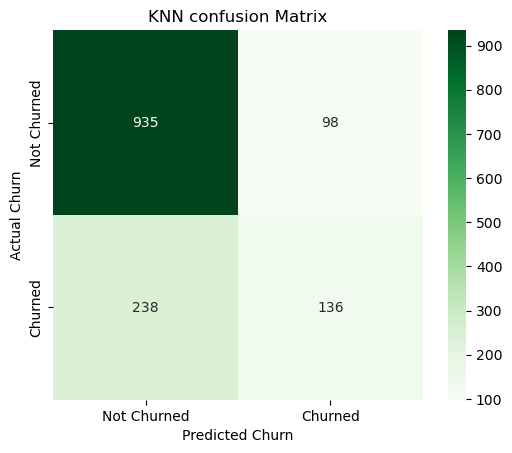

In [107]:
y_pred = lr.predict(X_test)

knn_confusion = confusion_matrix(y_test, y_pred)

sns.heatmap(
    knn_confusion.get(),
    cmap = 'Greens',
    annot = True,
    fmt = 'g',
    square = True,
    xticklabels = ['Not Churned', 'Churned'],
    yticklabels = ['Not Churned', 'Churned']
).set(
    ylabel = 'Actual Churn',
    xlabel = 'Predicted Churn',
    title = 'KNN confusion Matrix'
);

In [108]:
print(f'Test precision: {precision_score(y_test.to_numpy(), y_pred.to_numpy()):.3%}')
print(f'Test recall: {recall_score(y_test.to_numpy(), y_pred.to_numpy()):.3%}')
print(f'Test F1-score: {f1_score(y_test.to_numpy(), y_pred.to_numpy()):.3%}')

Test precision: 58.120%
Test recall: 36.364%
Test F1-score: 44.737%


In [109]:
# from cuml.model_selection import GridSearchCV
# parameters = {'C': np.linspace(.1, 2, 20), 
#               'penalty': ['l1', 'l2', 'elasticnet'],
#              'l1_ratio': np.linspace(0, 1, 11)
#              }
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# gridsearch = GridSearchCV(LogisticRegression(), parameters, n_jobs = -1, verbose = 2, cv =cv) # Max_tier
# gridsearch.fit(X_train.to_numpy(), y_train.to_numpy())
# gridsearch.best_params_

In [110]:
lr_tuned = LogisticRegression(C = 1.2, penalty = 'elasticnet', l1_ratio = 0.1)
lr_tuned = lr_tuned.fit(X_train, y_train)

In [111]:
pd.DataFrame(lr_tuned.coef_.to_numpy(), columns = df_pca.drop(columns = 'Customer Status').columns)

,PC1,PC2,PC3
0,0.221692,-0.549717,-0.109091


In [112]:
lr_tuned.intercept_.reset_index(name = 'Intercept').drop(columns = 'index')

,Intercept
0,-1.328636


In [113]:
print(f'Train accuracy: {lr_tuned.score(X_train, y_train):.3%}')
print(f'Test accuracy: {lr_tuned.score(X_test, y_test):.3%}')

Train accuracy: 75.786%
Test accuracy: 76.119%


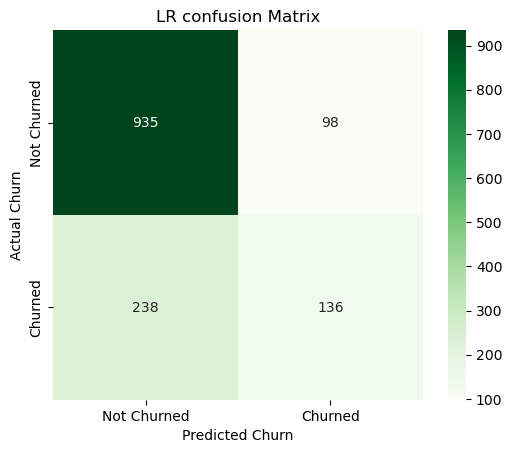

In [114]:
y_pred = lr_tuned.predict(X_test)

lr_confusion = confusion_matrix(y_test, y_pred)

sns.heatmap(
    lr_confusion.get(),
    cmap = 'Greens',
    annot = True,
    fmt = 'g',
    square = True,
    xticklabels = ['Not Churned', 'Churned'],
    yticklabels = ['Not Churned', 'Churned']
).set(
    ylabel = 'Actual Churn',
    xlabel = 'Predicted Churn',
    title = 'LR confusion Matrix'
);

In [115]:
print(f'Test precision: {precision_score(y_test.to_numpy(), y_pred.to_numpy()):.3%}')
print(f'Test recall: {recall_score(y_test.to_numpy(), y_pred.to_numpy()):.3%}')
print(f'Test F1-score: {f1_score(y_test.to_numpy(), y_pred.to_numpy()):.3%}')

Test precision: 58.120%
Test recall: 36.364%
Test F1-score: 44.737%


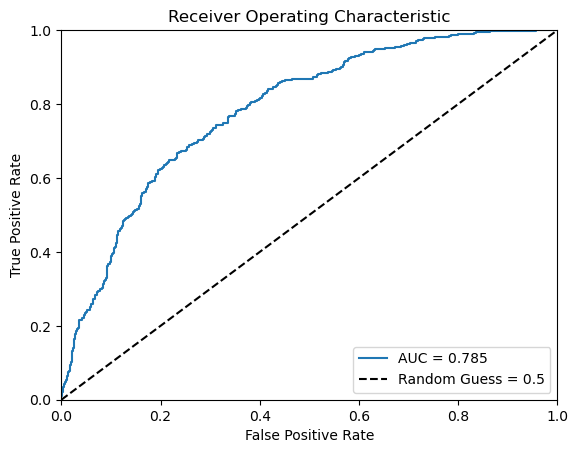

In [116]:
# calculate the fpr and tpr for all thresholds of the classification
probs = lr_tuned.predict_proba(X_test).iloc[:,1].to_numpy()
fpr, tpr, threshold = roc_curve(y_test.to_numpy(), probs)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'k--', label="Random Guess = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

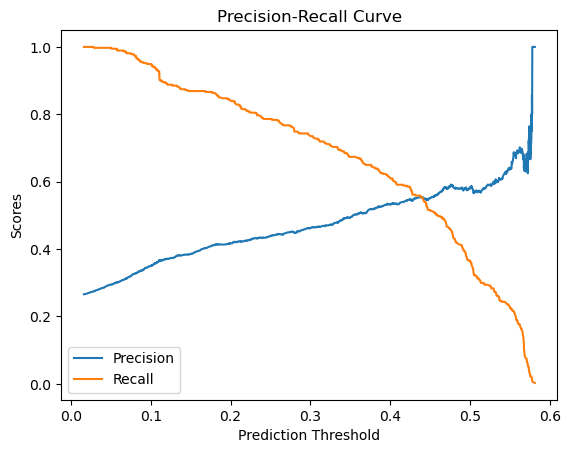

In [117]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

p_curve, r_curve, t_curve = precision_recall_curve(y_test.to_numpy(), lr_tuned.predict_proba(X_test).iloc[:, 1].to_numpy())

plt.plot(t_curve, p_curve[:-1], label='Precision')
plt.plot(t_curve, r_curve[:-1], label='Recall')
plt.xlabel('Prediction Threshold')
plt.ylabel('Scores')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

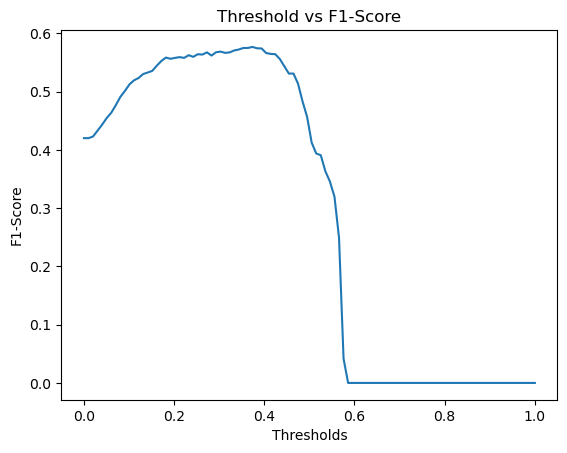

In [118]:
f1 = []
recall = []
precision = []

thresholds = np.linspace(0, 1, 100)

for thresh in thresholds:
    y_pred = (lr_tuned.predict_proba(X_test).iloc[:, 1].to_numpy() > thresh)
    recall.append(recall_score(y_test.to_numpy(), y_pred))
    precision.append(precision_score(y_test.to_numpy(), y_pred))
    f1.append(f1_score(y_test.to_numpy(), y_pred))
    
sns.lineplot(x = thresholds, y = f1)
plt.xlabel('Thresholds')
plt.ylabel('F1-Score')
plt.title('Threshold vs F1-Score')
plt.show()

In [119]:
thresh = thresholds[f1.index(max(f1))]
thresh

0.37373737373737376

In [120]:
metrics = pd.DataFrame({'Precision': precision,
             'Recall': recall,
             'F1-Score': f1}).sort_values('F1-Score', ascending = False)
metrics

,Precision,Recall,F1-Score
37,0.518124,0.649733,0.576512
36,0.507157,0.663102,0.574739
35,0.500994,0.673797,0.574686
38,0.523077,0.636364,0.574186
39,0.531963,0.622995,0.573892
...,...,...,...
95,0.000000,0.000000,0.000000
96,0.000000,0.000000,0.000000
97,0.000000,0.000000,0.000000
98,0.000000,0.000000,0.000000


#### Random Forest

In [121]:
# from cuml.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42)

rf.fit(X_train.to_numpy(), y_train.to_numpy())

RandomForestClassifier(random_state=42)

In [122]:
print(f"RF Train Accuracy: {rf.score(X_train.to_numpy(), y_train.to_numpy()):.3%}")
print(f"RF Test Accuracy: {rf.score(X_test.to_numpy(), y_test.to_numpy()):.3%}")
print(f"RF Test Precision: {precision_score(y_test.to_numpy(), rf.predict(X_test.to_numpy())):.3%}")
print(f"RF Test Recall: {recall_score(y_test.to_numpy(), rf.predict(X_test.to_numpy())):.3%}")
print(f"RF Test F1-Score: {f1_score(y_test.to_numpy(), rf.predict(X_test.to_numpy())):.3%}")

RF Train Accuracy: 100.000%
RF Test Accuracy: 80.952%
RF Test Precision: 66.159%
RF Test Recall: 58.021%
RF Test F1-Score: 61.823%


In [123]:
# from cuml.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import StratifiedKFold

# rf = RandomForestClassifier(random_state = 42)
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# params = {
#     'n_estimators': np.arange(start=50, stop=1051, step=100),
#     'max_features': ["sqrt", "log2", None],
#     'bootstrap': [True, False],
#     'max_samples': np.arange(start=0, stop=1.1, step=0.1),
#     'max_depth': np.arange(start=1, stop=11, step=1),
#     'min_samples_leaf': np.arange(start=1, stop=11, step=1),
# }

# random = RandomizedSearchCV(
#     rf, 
#     params,
#     n_jobs=-1,
#     random_state=42
# )

# random.fit(X_train.to_numpy(), y_train.to_numpy())

# random.best_params_

In [124]:
# rf = RandomForestClassifier(random_state = 42)

# params = {
#     'n_estimators': np.arange(start=700, stop=801, step=10),
#     'bootstrap': [True],
#     'max_features': ['log2'],
#     'max_samples': [0.2],
#     'max_depth': [5],
#     'min_samples_leaf': [6, 7, 8]    
# }

# grid = GridSearchCV(
#     rf, 
#     params,
#     # scoring="accuracy",
#     n_jobs=-1
# )

# grid.fit(X_train.to_numpy(), y_train.to_numpy())

# grid.best_params_

In [125]:
rf_tuned = RandomForestClassifier(bootstrap = True,
 max_depth = 5,
 max_features = 'log2',
 max_samples = 0.2,
 min_samples_leaf = 8,
 n_estimators = 790, random_state = 42)

rf_tuned.fit(X_train.to_numpy(), y_train.to_numpy())

print(f"RF CV Train Accuracy: {rf_tuned.score(X_train.to_numpy(), y_train.to_numpy()):.3%}")
print(f"RF CV Test Accuracy: {rf_tuned.score(X_test.to_numpy(), y_test.to_numpy()):.3%}")
print(f"RF CV Test Precision: {precision_score(y_test.to_numpy(), rf_tuned.predict(X_test.to_numpy())):.3%}")
print(f"RF CV Test Recall: {recall_score(y_test.to_numpy(), rf_tuned.predict(X_test.to_numpy())):.3%}")
print(f"RF CV Test F1-Score: {f1_score(y_test.to_numpy(), rf_tuned.predict(X_test.to_numpy())):.3%}")

RF CV Train Accuracy: 80.494%
RF CV Test Accuracy: 80.526%
RF CV Test Precision: 67.986%
RF CV Test Recall: 50.535%
RF CV Test F1-Score: 57.975%


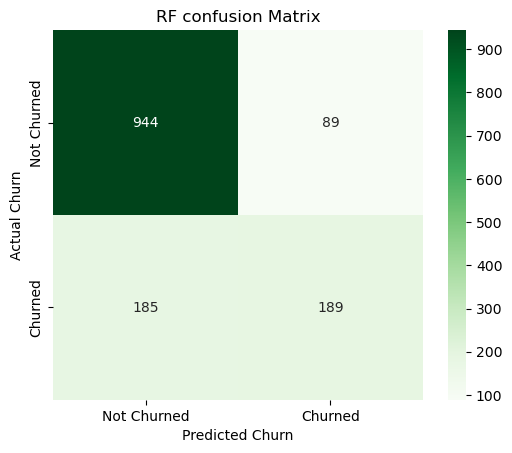

In [126]:
y_pred = rf_tuned.predict(X_test.to_numpy())

lr_confusion = confusion_matrix(y_test.to_numpy(), y_pred)

sns.heatmap(
    lr_confusion.get(),
    cmap = 'Greens',
    annot = True,
    fmt = 'g',
    square = True,
    xticklabels = ['Not Churned', 'Churned'],
    yticklabels = ['Not Churned', 'Churned']
).set(
    ylabel = 'Actual Churn',
    xlabel = 'Predicted Churn',
    title = 'RF confusion Matrix'
);

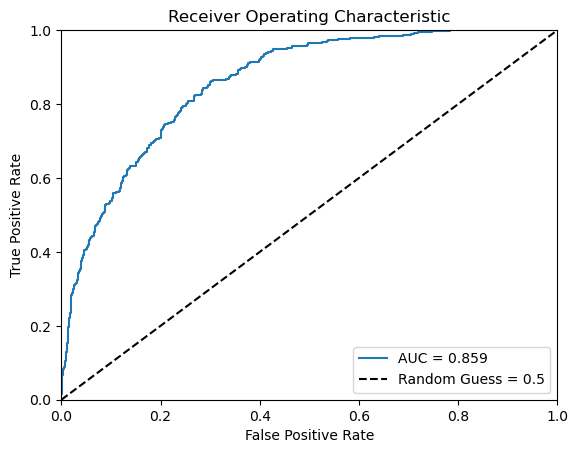

In [127]:
# calculate the fpr and tpr for all thresholds of the classification
probs = rf_tuned.predict_proba(X_test.to_numpy())[:,1]
fpr, tpr, threshold = roc_curve(y_test.to_numpy(), probs)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'k--', label="Random Guess = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

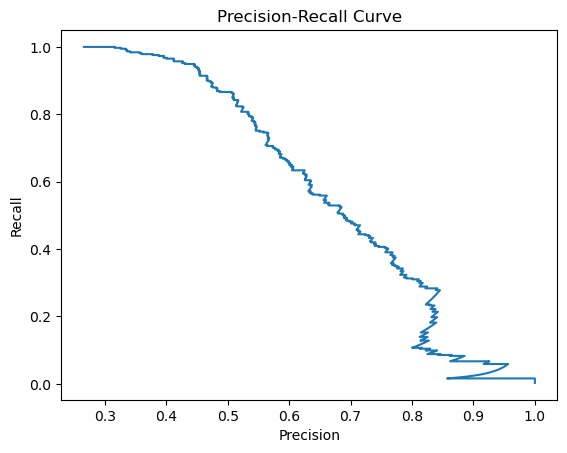

In [128]:
p_curve, r_curve, t_curve = precision_recall_curve(y_test.to_numpy(), rf_tuned.predict_proba(X_test.to_numpy())[:,1])

plt.plot(p_curve[:-1], r_curve[:-1], label='Precision-Recall Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')
# plt.legend()
plt.show()

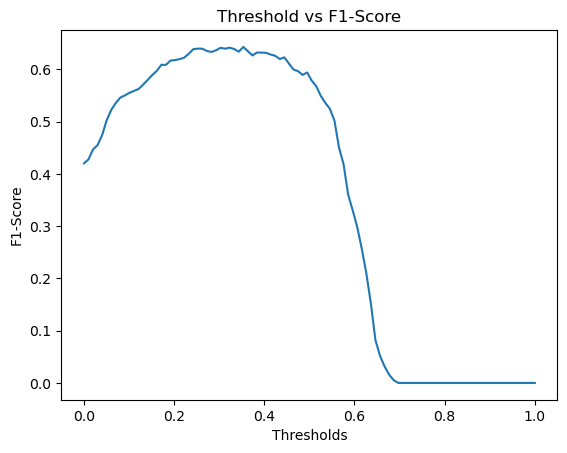

In [129]:
f1 = []
recall = []
precision = []

thresholds = np.linspace(0, 1, 100)

for thresh in thresholds:
    y_pred = (rf_tuned.predict_proba(X_test.to_numpy())[:,1] > thresh)
    recall.append(recall_score(y_test.to_numpy(), y_pred))
    precision.append(precision_score(y_test.to_numpy(), y_pred))
    f1.append(f1_score(y_test.to_numpy(), y_pred))
    
sns.lineplot(x = thresholds, y = f1)
plt.xlabel('Thresholds')
plt.ylabel('F1-Score')
plt.title('Threshold vs F1-Score')
plt.show()

In [130]:
thresh = thresholds[f1.index(max(f1))]
thresh

0.3535353535353536

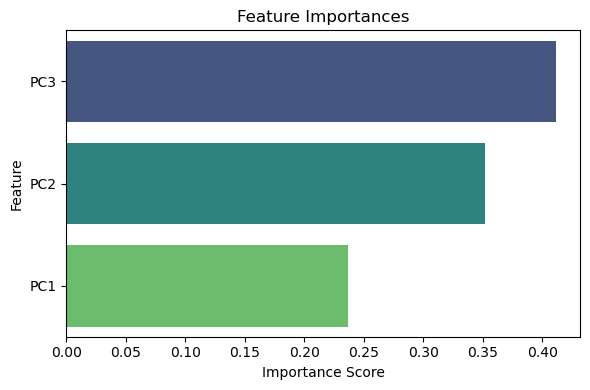

In [131]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_tuned.feature_importances_
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importances, 
    palette='viridis'
)

plt.title('Feature Importances', fontsize=12)
plt.xlabel('Importance Score', fontsize=10)
plt.ylabel('Feature', fontsize=10)
plt.tight_layout()
plt.show()

#### Support Vector Machine

In [132]:
from cuml.svm import SVC

svc_rbf = SVC(C=0.01, kernel='rbf', random_state=42)
svc_rbf.fit(X_train, y_train)

SVC()

In [133]:
total_support_vectors = svc_rbf.n_support_
print(f"Total number of support vectors: {total_support_vectors}")

Total number of support vectors: 3003


In [134]:
print(f"SVM Train Accuracy: {svc_rbf.score(X_train, y_train):.3%}")
print(f"SVM Test Accuracy: {svc_rbf.score(X_test, y_test):.3%}")
print(f"SVM Test Precision: {precision_score(y_test.to_numpy(), svc_rbf.predict(X_test.to_numpy())):.3%}")
print(f"SVM Test Recall: {recall_score(y_test.to_numpy(), svc_rbf.predict(X_test.to_numpy())):.3%}")
print(f"SVM Test F1-Score: {f1_score(y_test.to_numpy(), svc_rbf.predict(X_test.to_numpy())):.3%}")

SVM Train Accuracy: 73.441%
SVM Test Accuracy: 73.419%
SVM Test Precision: 0.000%
SVM Test Recall: 0.000%
SVM Test F1-Score: 0.000%


In [135]:
# from sklearn.model_selection import StratifiedKFold

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# C_values = np.logspace(0.01, 2, 100)

# param_grid = {'C': C_values}

# svc = SVC(kernel = 'rbf', probability=True, random_state = 42)

# grid_rbf= GridSearchCV(
#     estimator=svc,
#     param_grid=param_grid,
#     cv=cv,
#     scoring='accuracy',
#     n_jobs=-1
# )

# grid_rbf.fit(X_train.to_numpy(), y_train.to_numpy())

# # Best parameter
# best_C = grid_rbf.best_params_['C']
# best_score = grid_rbf.best_score_

# print(f"Best C value from cross-validation: {best_C}")
# print(f"Best cross-validation accuracy: {best_score:.3%}")

In [136]:
svc_tuned = SVC(C=91.15866991102556, kernel='rbf', probability=True, random_state=42)
svc_tuned.fit(X_train, y_train)

[W] [16:05:56.909868] Random state is currently ignored by probabilistic SVC


SVC()

In [137]:
# total_support_vectors = svc_tuned.n_support_
# print(f"Total number of support vectors: {total_support_vectors}")

In [138]:
print(f"SVM Train Accuracy: {svc_tuned.score(X_train, y_train):.3%}")
print(f"SVM Test Accuracy: {svc_tuned.score(X_test, y_test):.3%}")
print(f"SVM Test Precision: {precision_score(y_test.to_numpy(), svc_tuned.predict(X_test.to_numpy())):.3%}")
print(f"SVM Test Recall: {recall_score(y_test.to_numpy(), svc_tuned.predict(X_test.to_numpy())):.3%}")
print(f"SVM Test F1-Score: {f1_score(y_test.to_numpy(), svc_tuned.predict(X_test.to_numpy())):.3%}")

SVM Train Accuracy: 79.925%
SVM Test Accuracy: 81.379%
SVM Test Precision: 71.212%
SVM Test Recall: 50.267%
SVM Test F1-Score: 58.934%


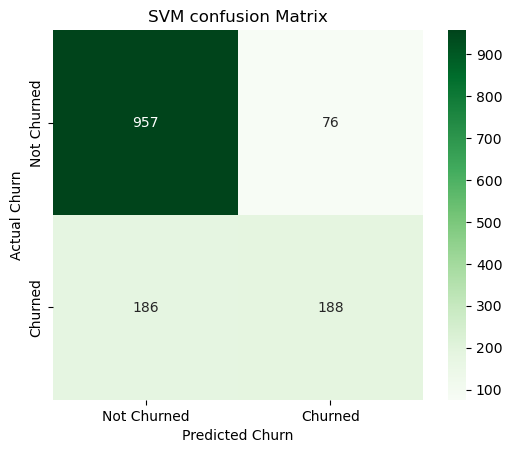

In [139]:
y_pred = svc_tuned.predict(X_test)

lr_confusion = confusion_matrix(y_test, y_pred)

sns.heatmap(
    lr_confusion.get(),
    cmap = 'Greens',
    annot = True,
    fmt = 'g',
    square = True,
    xticklabels = ['Not Churned', 'Churned'],
    yticklabels = ['Not Churned', 'Churned']
).set(
    ylabel = 'Actual Churn',
    xlabel = 'Predicted Churn',
    title = 'SVM confusion Matrix'
);

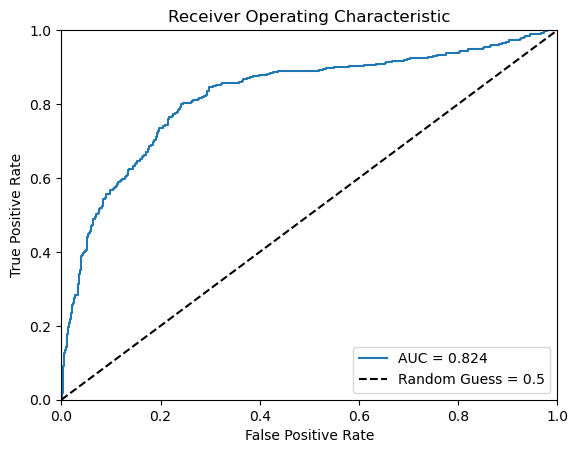

In [140]:
# calculate the fpr and tpr for all thresholds of the classification
probs = svc_tuned.predict_proba(X_test).iloc[:,1].to_numpy()
fpr, tpr, threshold = roc_curve(y_test.to_numpy(), probs)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'k--', label="Random Guess = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

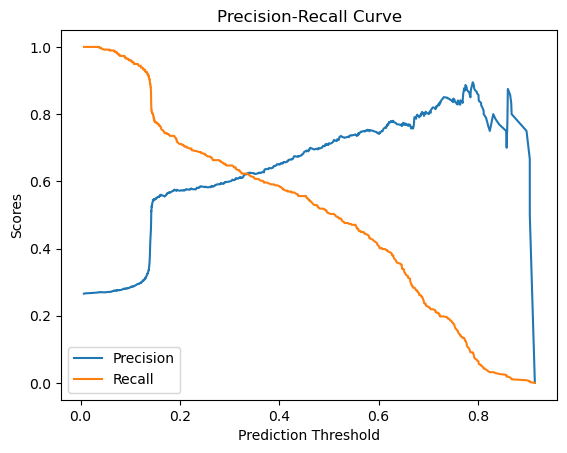

In [141]:
p_curve, r_curve, t_curve = precision_recall_curve(y_test.to_numpy(), svc_tuned.predict_proba(X_test).iloc[:, 1].to_numpy())

plt.plot(t_curve, p_curve[:-1], label='Precision')
plt.plot(t_curve, r_curve[:-1], label='Recall')
plt.xlabel('Prediction Threshold')
plt.ylabel('Scores')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

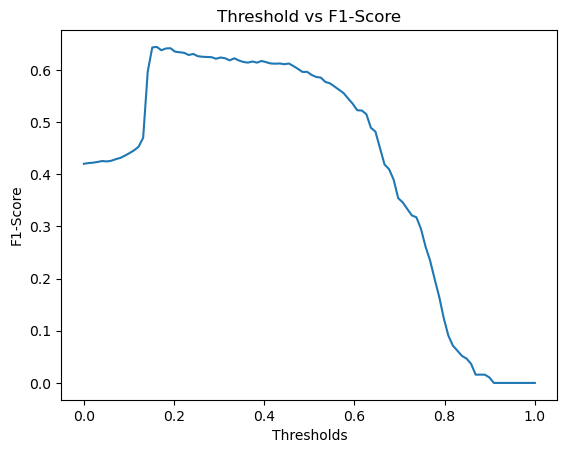

In [142]:
f1 = []
recall = []
precision = []

thresholds = np.linspace(0, 1, 100)

for thresh in thresholds:
    y_pred = (svc_tuned.predict_proba(X_test.to_numpy())[:,1] > thresh)
    recall.append(recall_score(y_test.to_numpy(), y_pred))
    precision.append(precision_score(y_test.to_numpy(), y_pred))
    f1.append(f1_score(y_test.to_numpy(), y_pred))
    
sns.lineplot(x = thresholds, y = f1)
plt.xlabel('Thresholds')
plt.ylabel('F1-Score')
plt.title('Threshold vs F1-Score')
plt.show()

In [143]:
thresh = thresholds[f1.index(max(f1))]
thresh

0.16161616161616163